In [1]:
# https://dacon.io/en/competitions/official/236037/overview/description

import pandas as pd
import numpy as np
import torch
import os
import random
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import f1_score

# for graphing
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_original = pd.read_csv('./dataset/df_augmented_.csv')
train_original.drop(columns=['ID'], inplace=True)
test = pd.read_csv('./dataset/test.csv')
test.drop(columns=['ID'], inplace=True)
submission = pd.read_csv('./datset/sample_submission.csv')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':1.6390181782185967e-05,
    'TRAIN_BATCH_SIZE': 64,
    'TEST_BATCH_SIZE': 128,
    'SEED':42
}

seed_everything(CFG['SEED']) # Seed 고정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps') 
print('학습을 진행하는 기기:',device)

학습을 진행하는 기기: cuda:0


In [4]:
train, val, y_train, y_val = train_test_split(train_original, train_original['label'], test_size=0.2, random_state=CFG['SEED'])
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [5]:
model_nm = 'klue/roberta-small'
base_model = AutoModel.from_pretrained(model_nm)
tokenizer = AutoTokenizer.from_pretrained(model_nm)

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

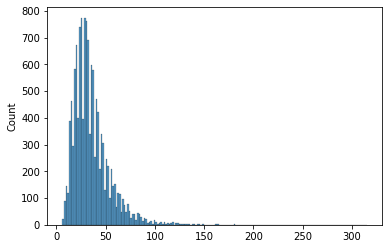

log value : 91.48731761060522


In [ ]:
# tokenizer를 통해 각 문장을 토큰화 시킨 리스트 형태로 반환함. 
# tokenizer는 토큰들이 어디에 저장되었는지 input_ids로 반환.
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in train['문장']]
sns.histplot(tokenizer_len)
plt.show()

print(f'log value : {np.mean(tokenizer_len)+3*np.std(tokenizer_len)}')

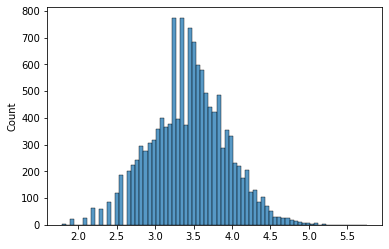

log value : 4.909803820030983
original value : 135.61280728232697


In [ ]:
# log를 씌워서 정규분포꼴로 정규화과정.
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}')
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

In [6]:
class SentenceTypeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels=None):
        texts = dataframe['문장'].values.tolist()

        self.texts = [tokenizer(text, padding='max_length', max_length=90, truncation=True, return_tensors='pt') for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        if self.labels is not None:
            type_tmp = self.labels['type'][idx]
            polarity_tmp = self.labels['polarity'][idx]
            tense_tmp = self.labels['tense'][idx]
            certainty_tmp = self.labels['certainty'][idx]
            return text, torch.Tensor(type_tmp), torch.Tensor(polarity_tmp), torch.Tensor(tense_tmp), torch.Tensor(certainty_tmp)
        else:
            return text, torch.Tensor([-1,-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1])

In [7]:
class SentenceClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.klue = base_model # from transformers package

        self.fc1 = nn.Linear(768, 32)
        self.relu = nn.ReLU()
        self.type_clf = nn.Linear(32,4)
        self.polarity_clf = nn.Linear(32,3)
        self.tense_clf = nn.Linear(32,3)
        self.certainty_clf = nn.Linear(32,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        # input_ids : token's id / attention_mask : make a model to focus on which token
        klue_out = self.klue(input_ids= input_ids, attention_mask = attention_mask)[0][:,0]

        x = self.fc1(klue_out)
        x = self.relu(x)

        type_output = self.type_clf(x)
        type_output = self.softmax(type_output)
        polarity_output = self.polarity_clf(x)
        polarity_output = self.softmax(polarity_output)
        tense_output = self.tense_clf(x)
        tense_output = self.softmax(tense_output)
        certainty_output = self.certainty_clf(x)
        certainty_output = self.softmax(certainty_output)

        return type_output, polarity_output, tense_output, certainty_output

In [8]:
def sentence_train(model, train_dataloader, val_dataloader, learning_rate, epochs, model_nm):
    best_val_loss = 99999999999999 # setting max (act as infinity)
    early_stopping_threshold_count = 0

    criterion = {
        'type' : nn.CrossEntropyLoss().to(device),
        'polarity' : nn.CrossEntropyLoss().to(device),
        'tense' : nn.CrossEntropyLoss().to(device),
        'certainty' : nn.CrossEntropyLoss().to(device)
    }

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)

    for epoch in range(epochs):
        total_loss_train = 0
        
        model.train() # 모델을 학습모드로
        
        # 여기가 학습과정
        for train_input, type_label, polarity_label, tense_label, certainty_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)

            optimizer.zero_grad()
            
            type_output, polarity_output, tense_output, certainty_output = model(input_ids, attention_mask) # from the forward function
            
            loss = 0.25*criterion['type'](type_output, torch.max(type_label.long(), 1)[1]) + \
                    0.25*criterion['polarity'](polarity_output, torch.max(polarity_label.long(), 1)[1]) + \
                    0.25*criterion['tense'](tense_output, torch.max(tense_label.long(), 1)[1]) + \
                    0.25*criterion['certainty'](certainty_output, torch.max(certainty_label.long(), 1)[1])
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
        
        # pred와 label을 담을 리스트를 각각 생성
        type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
        type_labels, polarity_labels, tense_labels, certainty_labels = [], [], [], []

        # 여기가 검증과정
        with torch.no_grad(): # since we should not change gradient for validation 
            total_loss_val = 0
            
            model.eval() # deactivate training
            
            # same process as the above
            for val_input, vtype_label, vpolarity_label, vtense_label, vcertainty_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                vtype_label = vtype_label.to(device)
                vpolarity_label = vpolarity_label.to(device)
                vtense_label = vtense_label.to(device)
                vcertainty_label = vcertainty_label.to(device)
                
                # 현재 output은 softmax값인데 이걸 f1 score으로 평가하기 위해선 one-hot encoding 된 라벨값과 비교해야함.
                # 단순히 argmax를 사용하게 되면 label encodin처럼 값이 나오므로 one-hot 꼴로 맞춰주기 위한 과정이 아래의 내용.
                vtype_output, vpolarity_output, vtense_output, vcertainty_output = model(input_ids, attention_mask) # from the forward function
                vtype_output = torch.zeros_like(vtype_output).scatter_(1,torch.argmax(vtype_output,dim = 1).unsqueeze(1),1.)
                vpolarity_output = torch.zeros_like(vpolarity_output).scatter_(1,torch.argmax(vpolarity_output,dim = 1).unsqueeze(1),1.)
                vtense_output = torch.zeros_like(vtense_output).scatter_(1,torch.argmax(vtense_output,dim = 1).unsqueeze(1),1.)
                vcertainty_output = torch.zeros_like(vcertainty_output).scatter_(1,torch.argmax(vcertainty_output,dim = 1).unsqueeze(1),1.)

                # 계산을 위해 각 예측값과 정답값들을 저장
                type_preds += vtype_output.detach().cpu().numpy().tolist()
                type_labels += vtype_label.detach().cpu().numpy().tolist()
                
                polarity_preds += vpolarity_output.detach().cpu().numpy().tolist()
                polarity_labels += vpolarity_label.detach().cpu().numpy().tolist()
                
                tense_preds += vtense_output.detach().cpu().numpy().tolist()
                tense_labels += vtense_label.detach().cpu().numpy().tolist()
                
                certainty_preds += vcertainty_output.detach().cpu().numpy().tolist()
                certainty_labels += vcertainty_label.detach().cpu().numpy().tolist()
                
                loss = 0.25*criterion['type'](vtype_output, torch.max(vtype_label.long(), 1)[1])+ \
                         0.25*criterion['polarity'](vpolarity_output, torch.max(vpolarity_label.long(), 1)[1]) + \
                         0.25*criterion['tense'](vtense_output, torch.max(vtense_label.long(), 1)[1]) + \
                         0.25*criterion['certainty'](vcertainty_output, torch.max(vcertainty_label.long(), 1)[1])

                total_loss_val += loss.item()

            type_f1 = f1_score(type_labels, type_preds, average='weighted')
            polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
            tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
            certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')
            total_f1 = (type_f1 + polarity_f1 + tense_f1 + certainty_f1) / 4
            
            print(f'---- Epochs: {epoch + 1} ---- \n ',
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .4f} \n ',
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .4f} \n ',
                  f'| Total F1_Score : {total_f1} \n 유형별 F1_score : {type_f1} \n 극성별 F1_score : {polarity_f1} \n 시제별 F1_score : {tense_f1} \n 확실성별 F1_score : {certainty_f1} ')
 
            if best_val_loss > total_loss_val:
              best_val_loss = total_loss_val # saving only the best one
              torch.save(model, f"./{model_nm+ '_best_epoch_'+str(epoch+1)}.pt")
              print("Saved model")
              early_stopping_threshold_count = 0
            else:
              early_stopping_threshold_count += 1 # checking how many epochs have passed that val_loss didn't increase
                
            if early_stopping_threshold_count >= 3: # ==> patience=1
              print("Early stopping")
              break

In [9]:
train_tmp = train[['문장', '유형', '극성', '시제', '확실성']]
train_tmp = pd.get_dummies(train_tmp, columns=['유형', '극성', '시제', '확실성'])
train_tmp

,문장,유형_대화형,유형_사실형,유형_예측형,유형_추론형,극성_긍정,극성_미정,극성_부정,시제_과거,시제_미래,시제_현재,확실성_불확실,확실성_확실
0,3년을 맡겨도 금리는 연 1.15∼2.20%로 큰 차이가 없다.,0,1,0,0,0,0,1,0,0,1,0,1
1,하지만 난관은 지금부터다.,0,0,0,1,1,0,0,0,0,1,0,1
2,2020년 새해 벽두 불쑥 제(화장실) 얘기부터 꺼내 죄송스럽긴 합니다.,1,0,0,0,1,0,0,0,0,1,0,1
3,오랜 세월 축적된 기술과 개발 노하우를 가진 미국과 유럽 항공기 제작사들을 짧은 시...,0,1,0,0,1,0,0,0,0,1,0,1
4,장애인주차구역에서 차가 나올 때는 장애인이 꼭 탑승하지 않아도 된다.,0,1,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9481,훅을 인수해서 OTT 사업 역량을 내재화한 덕분에 쿠팡플레이를 선보이고 단기간에 ＇...,1,0,0,0,1,0,0,1,0,0,0,1
9482,우리 몸에 들어온 온갖 잡균을 죽여주는 역할을 함은 물론 혈관을 건강하게 해줘 혈관...,0,1,0,0,1,0,0,0,0,1,0,1
9483,"고진영(1위), 박성현(2위), 김세영(6위), 이정은(9위), 김효주(12위)에 ...",0,0,0,1,1,0,0,0,1,0,1,0
9484,제약바이오 업계 A관계자는 ＂복제약인 바이오시밀러가 전체 의약품 수출을 견인한다고 ...,0,1,0,0,1,0,0,1,0,0,0,1


그 다음으로는 각 label별로 뽑아서 train_labels에 dictionary형태로 저장해준다.

In [10]:
train_type = train_tmp.iloc[:,1:5].values.tolist()
train_polarity = train_tmp.iloc[:,5:8].values.tolist()
train_tense = train_tmp.iloc[:,8:11].values.tolist()
train_certainty = train_tmp.iloc[:,11:13].values.tolist()
train_labels = {
    'type': train_type,
    'polarity': train_polarity,
    'tense': train_tense,
    'certainty': train_certainty
}

똑같은 방식으로 validation data도 만든다.

In [11]:
val_tmp = val[['문장', '유형', '극성', '시제', '확실성']]
val_tmp = pd.get_dummies(val_tmp, columns=['유형', '극성', '시제', '확실성'])

val_type = val_tmp.iloc[:,1:5].values.tolist()
val_polarity = val_tmp.iloc[:,5:8].values.tolist()
val_tense = val_tmp.iloc[:,8:11].values.tolist()
val_certainty = val_tmp.iloc[:,11:13].values.tolist()
val_labels = {
    'type': val_type,
    'polarity': val_polarity,
    'tense': val_tense,
    'certainty': val_certainty
}

In [12]:
train_dataloader = DataLoader(SentenceTypeDataset(train_tmp, tokenizer, train_labels), batch_size=CFG['TRAIN_BATCH_SIZE'], shuffle=True, num_workers=0) # num_workers: how many subprocesses to use for data loading  
val_dataloader = DataLoader(SentenceTypeDataset(val_tmp, tokenizer, val_labels), batch_size=CFG['TEST_BATCH_SIZE'], num_workers=0)

그 다음으로는 base_model (klue를 이용한 pretrained_model)을 기반으로해서 SentenceClassifier를 불러준다.

In [13]:
model = SentenceClassifier(base_model)

In [14]:
sentence_train(model, train_dataloader, val_dataloader, CFG['LEARNING_RATE'], CFG['EPOCHS'], 'kclue')

100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


---- Epochs: 1 ---- 
  | Train Loss:  0.8340 
  | Val Loss:  0.7009 
  | Total F1_Score : 0.7734800466059303 
 유형별 F1_score : 0.630396729095441 
 극성별 F1_score : 0.8643550212785934 
 시제별 F1_score : 0.7773695314142177 
 확실성별 F1_score : 0.8217989046354689 
Saved model


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


---- Epochs: 2 ---- 
  | Train Loss:  0.7474 
  | Val Loss:  0.6735 
  | Total F1_Score : 0.8343565600173002 
 유형별 F1_score : 0.7354536967027268 
 극성별 F1_score : 0.8643550212785934 
 시제별 F1_score : 0.8566471223939798 
 확실성별 F1_score : 0.8809703996939005 
Saved model


100%|██████████| 19/19 [00:12<00:00,  1.50it/s]


---- Epochs: 3 ---- 
  | Train Loss:  0.7041 
  | Val Loss:  0.6593 
  | Total F1_Score : 0.8627778277086937 
 유형별 F1_score : 0.8124942105179815 
 극성별 F1_score : 0.881631604530694 
 시제별 F1_score : 0.8746698592652922 
 확실성별 F1_score : 0.8823156365208069 
Saved model


100%|██████████| 19/19 [00:12<00:00,  1.51it/s]


---- Epochs: 4 ---- 
  | Train Loss:  0.6761 
  | Val Loss:  0.6480 
  | Total F1_Score : 0.8785203737435774 
 유형별 F1_score : 0.8225585725513569 
 극성별 F1_score : 0.8976217608455157 
 시제별 F1_score : 0.8904590970633394 
 확실성별 F1_score : 0.9034420645140975 
Saved model


100%|██████████| 19/19 [00:11<00:00,  1.67it/s]


---- Epochs: 5 ---- 
  | Train Loss:  0.6549 
  | Val Loss:  0.6413 
  | Total F1_Score : 0.8882402139523542 
 유형별 F1_score : 0.8371541721383985 
 극성별 F1_score : 0.9134034678605099 
 시제별 F1_score : 0.8921762818404846 
 확실성별 F1_score : 0.9102269339700239 
Saved model


100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


---- Epochs: 6 ---- 
  | Train Loss:  0.6393 
  | Val Loss:  0.6386 
  | Total F1_Score : 0.8931833093817793 
 유형별 F1_score : 0.8527338909224654 
 극성별 F1_score : 0.9218127505531283 
 시제별 F1_score : 0.8890563699249355 
 확실성별 F1_score : 0.909130226126588 
Saved model


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


---- Epochs: 7 ---- 
  | Train Loss:  0.6272 
  | Val Loss:  0.6365 
  | Total F1_Score : 0.8950883286042441 
 유형별 F1_score : 0.843769748724261 
 극성별 F1_score : 0.9415699649075271 
 시제별 F1_score : 0.8939240515661582 
 확실성별 F1_score : 0.9010895492190301 
Saved model


100%|██████████| 19/19 [00:10<00:00,  1.74it/s]


---- Epochs: 8 ---- 
  | Train Loss:  0.6166 
  | Val Loss:  0.6340 
  | Total F1_Score : 0.899744965101757 
 유형별 F1_score : 0.8573406677938453 
 극성별 F1_score : 0.9502082076617485 
 시제별 F1_score : 0.8911699362962013 
 확실성별 F1_score : 0.9002610486552333 
Saved model


100%|██████████| 19/19 [00:10<00:00,  1.74it/s]


---- Epochs: 9 ---- 
  | Train Loss:  0.6075 
  | Val Loss:  0.6332 
  | Total F1_Score : 0.9002017796284996 
 유형별 F1_score : 0.8452563142735818 
 극성별 F1_score : 0.9512091761396309 
 시제별 F1_score : 0.8968997458812104 
 확실성별 F1_score : 0.907441882219575 
Saved model


100%|██████████| 19/19 [00:10<00:00,  1.74it/s]


---- Epochs: 10 ---- 
  | Train Loss:  0.6008 
  | Val Loss:  0.6320 
  | Total F1_Score : 0.9030995567462434 
 유형별 F1_score : 0.8529591493169237 
 극성별 F1_score : 0.9565880096480789 
 시제별 F1_score : 0.8920949699292162 
 확실성별 F1_score : 0.9107560980907545 
Saved model


100%|██████████| 19/19 [00:11<00:00,  1.72it/s]


---- Epochs: 11 ---- 
  | Train Loss:  0.5952 
  | Val Loss:  0.6283 
  | Total F1_Score : 0.9066436934712568 
 유형별 F1_score : 0.8581168012745475 
 극성별 F1_score : 0.9588561943596564 
 시제별 F1_score : 0.8943997581190386 
 확실성별 F1_score : 0.9152020201317851 
Saved model


100%|██████████| 19/19 [00:12<00:00,  1.56it/s]


---- Epochs: 12 ---- 
  | Train Loss:  0.5901 
  | Val Loss:  0.6291 
  | Total F1_Score : 0.9049903410408315 
 유형별 F1_score : 0.8536352654590161 
 극성별 F1_score : 0.9597013826327145 
 시제별 F1_score : 0.8953717461084609 
 확실성별 F1_score : 0.9112529699631351 


100%|██████████| 19/19 [00:12<00:00,  1.53it/s]


---- Epochs: 13 ---- 
  | Train Loss:  0.5869 
  | Val Loss:  0.6279 
  | Total F1_Score : 0.9074683796197037 
 유형별 F1_score : 0.8596128423671251 
 극성별 F1_score : 0.9613122767783171 
 시제별 F1_score : 0.8959722962665975 
 확실성별 F1_score : 0.9129761030667752 
Saved model


100%|██████████| 19/19 [00:12<00:00,  1.48it/s]


---- Epochs: 14 ---- 
  | Train Loss:  0.5833 
  | Val Loss:  0.6281 
  | Total F1_Score : 0.9072295882261258 
 유형별 F1_score : 0.8558577888920703 
 극성별 F1_score : 0.9645516117049255 
 시제별 F1_score : 0.8944242611441015 
 확실성별 F1_score : 0.914084691163406 


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


---- Epochs: 15 ---- 
  | Train Loss:  0.5800 
  | Val Loss:  0.6261 
  | Total F1_Score : 0.9092802932666282 
 유형별 F1_score : 0.858537566994577 
 극성별 F1_score : 0.9633867617647637 
 시제별 F1_score : 0.8978164621754225 
 확실성별 F1_score : 0.9173803821317497 
Saved model


100%|██████████| 19/19 [00:12<00:00,  1.57it/s]


---- Epochs: 16 ---- 
  | Train Loss:  0.5777 
  | Val Loss:  0.6278 
  | Total F1_Score : 0.9088376028019363 
 유형별 F1_score : 0.8614898404473968 
 극성별 F1_score : 0.9636661058723016 
 시제별 F1_score : 0.8920178436099152 
 확실성별 F1_score : 0.9181766212781315 


100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


---- Epochs: 17 ---- 
  | Train Loss:  0.5767 
  | Val Loss:  0.6296 
  | Total F1_Score : 0.9069374985417109 
 유형별 F1_score : 0.8577819059608072 
 극성별 F1_score : 0.9646565937612858 
 시제별 F1_score : 0.8835178895648369 
 확실성별 F1_score : 0.9217936048799139 


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]

---- Epochs: 18 ---- 
  | Train Loss:  0.5745 
  | Val Loss:  0.6270 
  | Total F1_Score : 0.9084998831426817 
 유형별 F1_score : 0.8583796201819699 
 극성별 F1_score : 0.9652335420620417 
 시제별 F1_score : 0.8937505562533404 
 확실성별 F1_score : 0.9166358140733749 
Early stopping


In [15]:
def get_type_predictions(model, loader):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
    model = model.to(device)
    
    type_probs, polarity_probs, tense_probs, clarity_probs = [], [], [], []
    with torch.no_grad():
        model.eval()
        for data_input, _, _, _, _ in tqdm(loader):
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)


            type_output, polarity_output, tense_output, clarity_output = model(input_ids, attention_mask)
            type_probs.append(type_output)
            polarity_probs.append(polarity_output)
            tense_probs.append(tense_output)
            clarity_probs.append(clarity_output)
    
    return torch.cat(type_probs).cpu().detach().numpy(), \
            torch.cat(polarity_probs).cpu().detach().numpy(), \
            torch.cat(tense_probs).cpu().detach().numpy(), \
            torch.cat(clarity_probs).cpu().detach().numpy()

In [16]:
model = torch.load("kclue_best_epoch_15.pt")
test_dataloader = DataLoader(SentenceTypeDataset(test, tokenizer), batch_size=CFG['TEST_BATCH_SIZE'], shuffle=False)

In [20]:
#val_pred_type, val_pred_polarity, val_pred_tense, val_pred_certainty = get_type_predictions(model, val_dataloader)

#val_type = ['대화형' if i==0 else '사실형' if i==1 else '예측형' if i==2 else '추론형' for i in [np.argmax(p) for p in val_pred_type]]
#val_polarity = ['긍정' if i==0 else '미정' if i==1 else '부정' for i in [np.argmax(p) for p in val_pred_polarity]]
#val_type = ['과거' if i==0 else '미래' if i==1 else '현재' for i in [np.argmax(p) for p in val_pred_tense]]
#val_type = ['불확실' if i==0 else '확실' for i in [np.argmax(p) for p in val_pred_certainty]]

In [17]:
test_pred_type, test_pred_polarity, test_pred_tense, test_pred_certainty = get_type_predictions(model, test_dataloader)

100%|██████████| 56/56 [00:36<00:00,  1.54it/s]


In [18]:
test_type = ['대화형' if i==0 else '사실형' if i==1 else '예측형' if i==2 else '추론형' for i in [np.argmax(p) for p in test_pred_type]]
test_polarity = ['긍정' if i==0 else '미정' if i==1 else '부정' for i in [np.argmax(p) for p in test_pred_polarity]]
test_tense = ['과거' if i==0 else '미래' if i==1 else '현재' for i in [np.argmax(p) for p in test_pred_tense]]
test_certainty = ['불확실' if i==0 else '확실' for i in [np.argmax(p) for p in test_pred_certainty]]

In [19]:
label_sum = []
for i in range(len(test_type)):
    label_sum.append(f'{test_type[i]}-{test_polarity[i]}-{test_tense[i]}-{test_certainty[i]}')

submission['label'] = pd.Series(label_sum)
#submission.to_csv('./result/vocab + augment + optuna.csv', index=False)

### 한국어 자막 데이터셋에 적용

In [20]:
from Korpora import Korpora
Korpora.fetch('open_subtitles')
movie_set = Korpora.load('open_subtitles')

[Korpora] Corpus `open_subtitles` is already installed at C:\Users\A\Korpora\open_subtitles\en-ko.tmx.gz
[Korpora] Corpus `open_subtitles` is already installed at C:\Users\A\Korpora\open_subtitles\en-ko.tmx

    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : TRAC (https://trac.edgewall.org/)
    Repository : http://opus.nlpl.eu/OpenSubtitles-v2018.php
    References :
        - P. Lison and J. Tiedemann, 2016, OpenSubtitles2016: Extracting Large Parallel Corpora
          from Movie and TV Subtitles. In Proceedings of the 10th International Conference on
          Language Resources and Evaluation (LREC 2016)

    This is a new collection of translated movie subtitles from http://www.opensubtitles.org/.

    [[ IMPORTANT ]]
    If you use the OpenSubtitle corpus: Plea

In [21]:
# 데이터프레임 생성 -> 너무 많아서 500개 까지만 진행
movie_df = pd.DataFrame(movie_set.get_all_texts(),columns = ['문장'])
print(movie_df.shape)
movie_df = movie_df.iloc[:500,:]
movie_df

(1269683, 1)


,문장
0,"폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘..."
1,우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!
2,황새 아저씨를 기다리세요
3,찾아와 선물을 주실 거예요
4,가난하든 부자이든 상관이 없답니다
...,...
495,왜 그런 생각을 못했지?
496,"네 귀를 좀 봐, 덤보!"
497,웬만한 날개보다도 크잖아
498,옛날엔 애물 단지였지만 이젠 보물 단지가 될 거야


In [22]:
model = torch.load("kclue_best_epoch_15.pt") # 성능이 제일 좋았던 (내꺼 기준 augmentation tunning 모델 불러옴)
test_dataloader = DataLoader(SentenceTypeDataset(movie_df, tokenizer), batch_size=128, shuffle=False)

In [23]:
our_test_pred_type, our_test_pred_polarity, our_test_pred_tense, our_test_pred_certainty = get_type_predictions(model, test_dataloader) # 모델 inference

100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


In [24]:
# label 형식에 맞게 변환해주고
our_test_type = ['대화형' if i==0 else '사실형' if i==1 else '예측형' if i==2 else '추론형' for i in [np.argmax(p) for p in our_test_pred_type]]
our_test_polarity = ['긍정' if i==0 else '미정' if i==1 else '부정' for i in [np.argmax(p) for p in our_test_pred_polarity]]
our_test_tense = ['과거' if i==0 else '미래' if i==1 else '현재' for i in [np.argmax(p) for p in our_test_pred_tense]]
our_test_certainty = ['불확실' if i==0 else '확실' for i in [np.argmax(p) for p in our_test_pred_certainty]]

In [25]:
# label형식에 맞게 다시 합쳐주고
label_sum = []
for i in range(len(our_test_type)):
    label_sum.append(f'{our_test_type[i]}-{our_test_polarity[i]}-{our_test_tense[i]}-{our_test_certainty[i]}')

# submission 저장.
movie_df['label'] = label_sum
#movie_df.to_csv('./inference/movie_classification.csv', index=False)

In [26]:
movie_df.head(10)

,문장,label
0,"폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘...",사실형-긍정-현재-확실
1,우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!,대화형-부정-현재-확실
2,황새 아저씨를 기다리세요,대화형-긍정-현재-확실
3,찾아와 선물을 주실 거예요,대화형-긍정-현재-확실
4,가난하든 부자이든 상관이 없답니다,대화형-부정-현재-확실
5,백만장자도 하나 가난뱅이도 하나,사실형-긍정-현재-불확실
6,황새 아저씨를 기다리세요,대화형-긍정-현재-확실
7,도망쳐도 소용없어요 반드시 찾아내니까요,대화형-긍정-현재-확실
8,세상 끝에 있어도 하늘 꼭대기에 있어도,사실형-긍정-현재-확실
9,황새 아저씨는 찾아간답니다,대화형-긍정-현재-확실


In [32]:
movie_df[movie_df['label'].str.contains("대화형") == True]

,문장,label
1,우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!,대화형-긍정-현재-불확실
2,황새 아저씨를 기다리세요,대화형-긍정-현재-확실
3,찾아와 선물을 주실 거예요,대화형-긍정-현재-확실
4,가난하든 부자이든 상관이 없답니다,대화형-긍정-현재-확실
6,황새 아저씨를 기다리세요,대화형-긍정-현재-확실
...,...,...
494,내가 바보였어,대화형-긍정-과거-확실
495,왜 그런 생각을 못했지?,대화형-긍정-과거-확실
496,"네 귀를 좀 봐, 덤보!",대화형-긍정-현재-확실
497,웬만한 날개보다도 크잖아,대화형-긍정-현재-확실


In [33]:
len(movie_df)

500

In [34]:
movie_df['label'].value_counts()

대화형-긍정-현재-확실     223
추론형-긍정-현재-확실      98
사실형-긍정-현재-확실      75
대화형-긍정-현재-불확실     51
대화형-긍정-과거-확실      27
대화형-미정-현재-불확실      6
추론형-긍정-미래-확실       5
대화형-긍정-미래-확실       5
사실형-긍정-과거-확실       3
대화형-긍정-과거-불확실      3
추론형-긍정-미래-불확실      2
추론형-긍정-현재-불확실      1
사실형-긍정-미래-확실       1
Name: label, dtype: int64

#### 혐오댓글 데이터셋 사용

In [ ]:
from Korpora import Korpora
Korpora.fetch('korean_hate_speech')
hate_set = Korpora.load('korean_hate_speech')

[Korpora] Corpus `korean hate speech` is already installed at /root/Korpora/korean_hate_speech/unlabeled/unlabeled_comments_1.txt
[Korpora] Corpus `korean hate speech` is already installed at /root/Korpora/korean_hate_speech/unlabeled/unlabeled_comments_2.txt
[Korpora] Corpus `korean hate speech` is already installed at /root/Korpora/korean_hate_speech/unlabeled/unlabeled_comments_3.txt
[Korpora] Corpus `korean hate speech` is already installed at /root/Korpora/korean_hate_speech/unlabeled/unlabeled_comments_4.txt
[Korpora] Corpus `korean hate speech` is already installed at /root/Korpora/korean_hate_speech/unlabeled/unlabeled_comments_5.txt
[Korpora] Corpus `korean hate speech` is already installed at /root/Korpora/korean_hate_speech/news_title/unlabeled_comments.news_title_1.txt
[Korpora] Corpus `korean hate speech` is already installed at /root/Korpora/korean_hate_speech/news_title/unlabeled_comments.news_title_2.txt
[Korpora] Corpus `korean hate speech` is already installed at /roo

In [ ]:
hate_df = pd.DataFrame(hate_set.get_all_texts(),columns = ['문장'])
print(hate_df.shape)
hate_df = hate_df.iloc[:500,:]
hate_df

(2043234, 1)


,문장
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.
1,지현우 나쁜놈
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라
3,설마 ㅈ 현정 작가 아니지??
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...
...,...
495,한효주가 뭐가 아쉬워서 사람 많은 클럽에서 침까지 질질 흘리며 콧물까지흘리며 마약을...
496,윤정언니 힘내세요~ 앞으로 꽃길만걷기를...
497,페미들 ㄹㅇ 토나온다
498,안타깝네요ㅜㅜ좋아하던 배우인데ㅜ


In [ ]:
model = torch.load("./kclue_epoch_12_tunning.pt") # 성능이 제일 좋았던 (내꺼 기준 augmentation tunning 모델 불러옴)
test_dataloader = DataLoader(SentenceTypeDataset(hate_df, tokenizer), batch_size=128, shuffle=False)
# test_dataloader = DataLoader(SentenceTypeDataset(test, tokenizer), batch_size=CFG['BATCH_SIZE'], shuffle=False) # DataLoader로 구성하고, Shuffle은 무조건 False!

In [ ]:
our_test_pred_type, our_test_pred_polarity, our_test_pred_tense, our_test_pred_certainty = get_type_predictions(model, test_dataloader) # 모델 inference

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# label 형식에 맞게 변환해주고
our_test_type = ['대화형' if i==0 else '사실형' if i==1 else '예측형' if i==2 else '추론형' for i in [np.argmax(p) for p in our_test_pred_type]]
our_test_polarity = ['긍정' if i==0 else '미정' if i==1 else '부정' for i in [np.argmax(p) for p in our_test_pred_polarity]]
our_test_tense = ['과거' if i==0 else '미래' if i==1 else '현재' for i in [np.argmax(p) for p in our_test_pred_tense]]
our_test_certainty = ['불확실' if i==0 else '확실' for i in [np.argmax(p) for p in our_test_pred_certainty]]

In [ ]:
# label형식에 맞게 다시 합쳐주고
label_sum = []
for i in range(len(our_test_type)):
    label_sum.append(f'{our_test_type[i]}-{our_test_polarity[i]}-{our_test_tense[i]}-{our_test_certainty[i]}')

# submission 저장.
hate_df['label'] = label_sum
# hate_df.to_csv('./inference/hate_classification.csv', index=False)

In [ ]:
hate_df

,문장,label
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,추론형-긍정-과거-확실
1,지현우 나쁜놈,사실형-긍정-현재-확실
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,대화형-긍정-현재-확실
3,설마 ㅈ 현정 작가 아니지??,대화형-부정-현재-불확실
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,대화형-긍정-현재-확실
...,...,...
495,한효주가 뭐가 아쉬워서 사람 많은 클럽에서 침까지 질질 흘리며 콧물까지흘리며 마약을...,대화형-긍정-과거-확실
496,윤정언니 힘내세요~ 앞으로 꽃길만걷기를...,대화형-긍정-현재-확실
497,페미들 ㄹㅇ 토나온다,추론형-긍정-현재-확실
498,안타깝네요ㅜㅜ좋아하던 배우인데ㅜ,대화형-긍정-현재-확실
